# Import Libraries

In [1]:
!pip install mlflow -q
!pip install dagshub -q
!pip install torchviz graphviz
!pip install torchsummary

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.10.2 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.2 requires botocore<1.35.37,>=1.35.16, but you have botocore 1.29.165 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.
ydata-profiling 4.12.0 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible

In [2]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
import random 
from PIL import Image
import matplotlib.pyplot as plt
import torch
from collections import Counter
import hashlib
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torchviz import make_dot
import mlflow

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Load & Preprocessing

In [4]:
train_path="/kaggle/input/labeled-chest-xray-images/chest_xray/train"
test_path="/kaggle/input/labeled-chest-xray-images/chest_xray/test"

orig_transform = transforms.Compose([
        # Ensure images are single-channel
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,.5,.5), std=(0.5,.5,.5)), 
])
orig_dataset=datasets.ImageFolder(root=train_path,transform=orig_transform)
test_dataset=datasets.ImageFolder(root=test_path,transform=orig_transform)

In [5]:
print(len(orig_dataset))


5232


In [6]:
class_names=orig_dataset.classes
class_ids=orig_dataset.class_to_idx
print(class_names)
print(class_ids)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


## Visualization

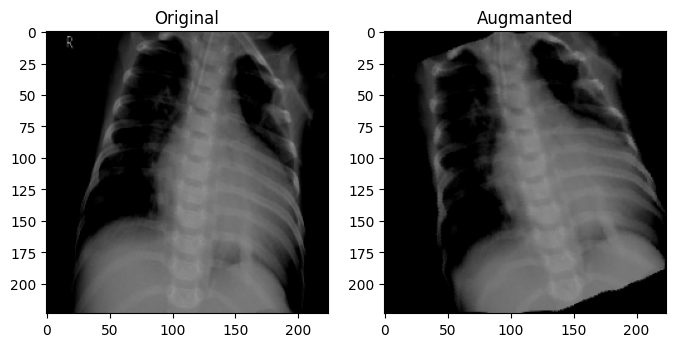

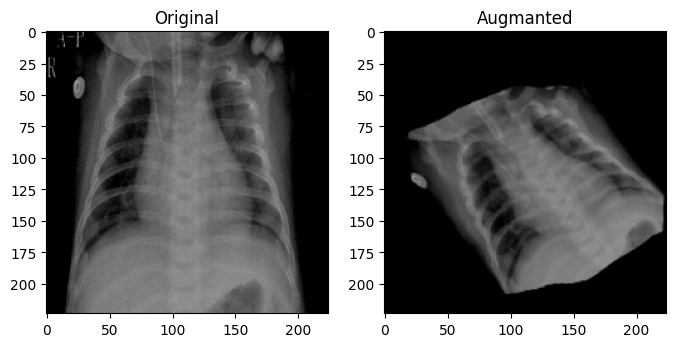

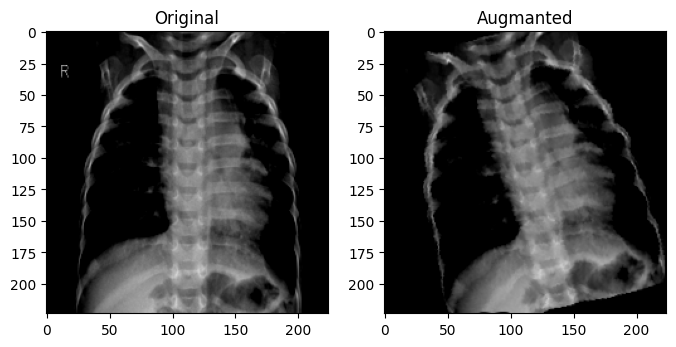

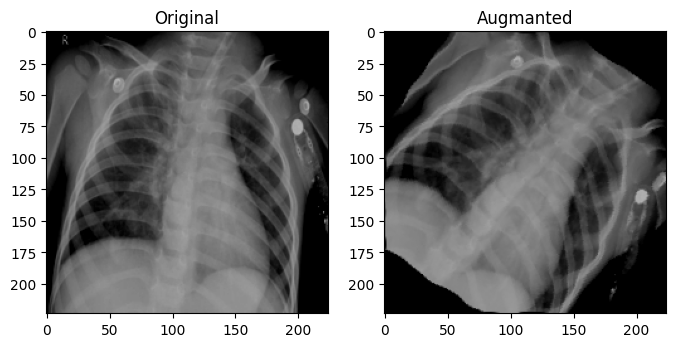

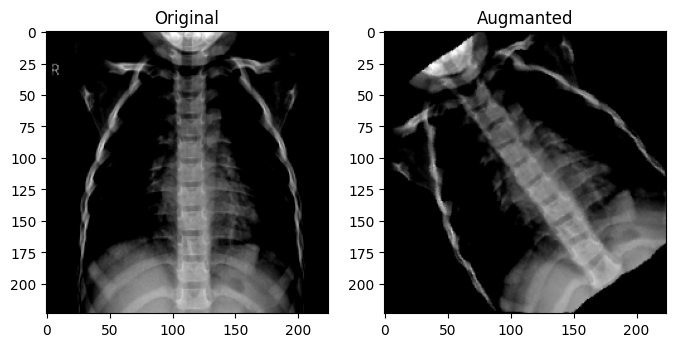

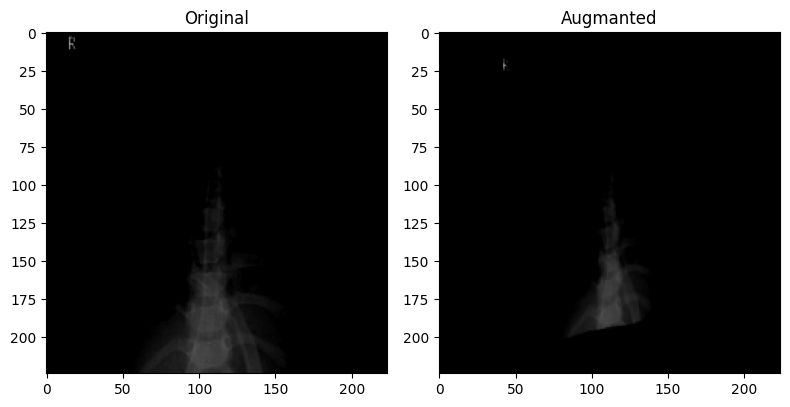

In [7]:
aug_transform = transforms.Compose([
        # Ensure images are single-channel
    transforms.RandomRotation(45), 
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ElasticTransform(alpha=50.0),
   
])


for _ in range(6):
    fig,(axis1,axis2)=plt.subplots(1,2,figsize=(8,5))

    img,label=random.choice(orig_dataset)
    
    aug_img=aug_transform(img)
    img_permuted=img.permute(1,2,0)
    aug_img_permuted=aug_img.permute(1,2,0)

    axis1.imshow(img_permuted)
    axis1.set_title("Original")

    axis2.imshow(aug_img_permuted)
    axis2.set_title("Augmanted")

plt.tight_layout()
plt.show()

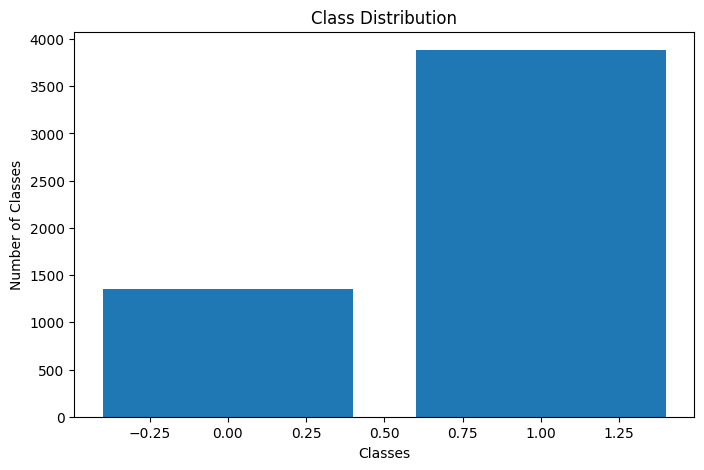

In [8]:
classes_count=Counter(orig_dataset.targets)
plt.figure(figsize=(8,5))
plt.bar(classes_count.keys(),classes_count.values())

plt.xlabel("Classes")
plt.ylabel("Number of Classes")
plt.title("Class Distribution")
plt.show()

**Train data**

In [9]:
orig_dataset.classes

['NORMAL', 'PNEUMONIA']

In [10]:
class Visualize_images:
    def __init__(self,dataset,num_images):
        
        self.num_images=num_images
        
        self.dataset=dataset
    def visualize_images(self,class_name):
        class_idx = self.dataset.class_to_idx[class_name]
    
        images = [img for img, label in self.dataset if label == class_idx]
        plt.figure(figsize=(12, 8))
        for i in range(min(self.num_images, len(images))):
            img = transforms.ToPILImage()(images[i])  # Convert tensor to PIL image
            plt.subplot(1, self.num_images, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
        plt.tight_layout()
        plt.show()



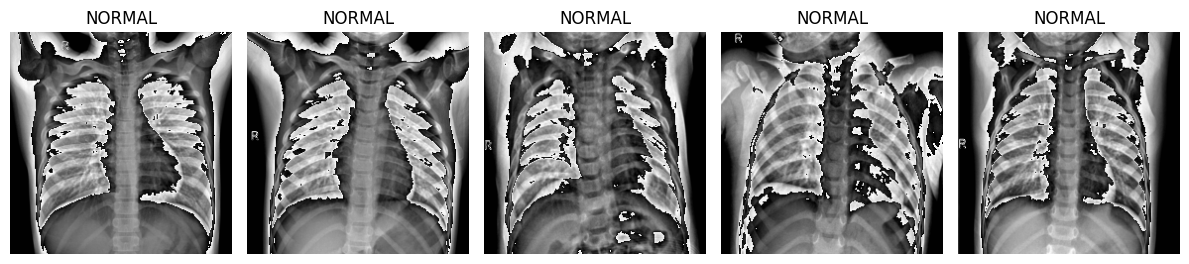

In [11]:
v=Visualize_images(orig_dataset,5)
v.visualize_images('NORMAL')

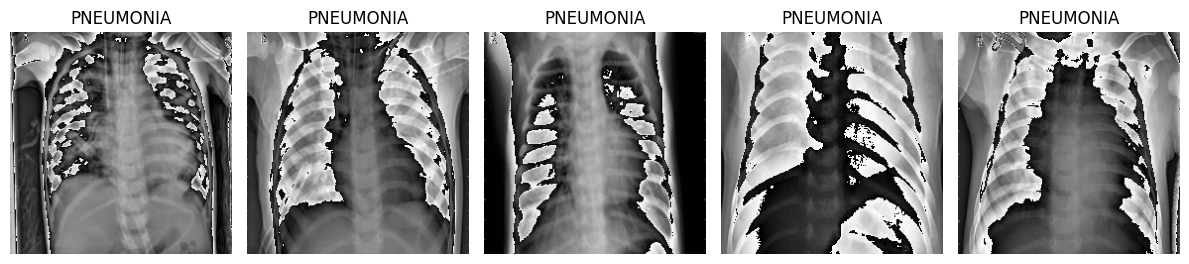

In [12]:
v.visualize_images('PNEUMONIA')

## Cleaning

In [13]:
import hashlib
from torchvision import datasets

class Duplicates:
    def __init__(self, dataset):
        self.dataset = dataset  
        self.hashs = {}  
        self.duplicates = []  
        
    def calculate_hash(self, img_file):
        """Calculate the hash of the image file"""
        with open(img_file, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
            
    def find_duplicates(self):
        """Find duplicates in the dataset"""
        for path, _ in self.dataset.imgs: 
            encoded_number = self.calculate_hash(path)
            if encoded_number in self.hashs:
                self.duplicates.append(path)
            else:
                self.hashs[encoded_number] = path
        return len(self.duplicates)

    def remove_duplicates(self):
        """Remove duplicate images from the dataset"""
        for dup_path in self.duplicates:
            try:
                os.remove(dup_path)  # Delete the duplicate file
                
            except Exception as e:
                print(f"Error removing file {dup_path}: {e}")
        print(f"Removed {len(self.duplicates)} duplicate images.")
       

In [14]:
duplicates=Duplicates(orig_dataset)
d=duplicates.find_duplicates()
print(d)
duplicates.remove_duplicates()

26
Error removing file /kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-3780378-0002.jpeg: [Errno 30] Read-only file system: '/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-3780378-0002.jpeg'
Error removing file /kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-266879-0002.jpeg: [Errno 30] Read-only file system: '/kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-266879-0002.jpeg'
Error removing file /kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-4615614-0004.jpeg: [Errno 30] Read-only file system: '/kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-4615614-0004.jpeg'
Error removing file /kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-4647402-0004.jpeg: [Errno 30] Read-only file system: '/kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-4647402-0004.jpeg'
Error removing file /kaggle/i

In [15]:
class imbalanced_data:

    def __init__(self,dataset):
        self.dataset = dataset
        self.targets = dataset.targets
        self.class_counts = Counter(self.targets)
        self.class_weights = torch.tensor(
            [len(dataset) / count for count in pd.Series(self.class_counts).sort_index().values]
        )
    

    def compute_sample_weights(self):

        sample_weights=[]
        for label in self.targets:
                class_weight=self.class_weights[label].item()
                sample_weights.append(class_weight)
        return sample_weights
        
    def get_weighted_sampler(self):
        sample_weights=self.compute_sample_weights()
        sampler=WeightedRandomSampler(weights=sample_weights,
                                     num_samples=len(sample_weights),
                                      replacement=True
                                     )
        return sampler
    

In [16]:
def validate_labels(dataset):
    all_correct = True
    for img_path, label in dataset.imgs:
        
        folder_name = os.path.basename(os.path.dirname(img_path))
        
        
        if (folder_name == 'NORMAL' and label != 0) or (folder_name == 'PNEUMONIA' and label != 1):
            print(f"Mismatch found! Image: {img_path}, Label: {label}")
            all_correct = False

    if all_correct:
        print("All images are correctly labeled.")
    else:
        print("Some images have incorrect labels.")

# Run the validation
validate_labels(orig_dataset)

All images are correctly labeled.


In [17]:
orig_dataset.classes

['NORMAL', 'PNEUMONIA']

# Baseline

In [18]:
train_transform = transforms.Compose([
        # Ensure images are single-channel
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),
  
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ElasticTransform(alpha=50.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,.5,.5), std=(0.5,.5,.5)),  # Adjust for grayscale
])


test_transform=transforms.Compose([
    
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5,.5,.5),std=(.5,.5,.5))
])

In [19]:
train_dataset=datasets.ImageFolder(root=train_path,transform=train_transform)
test_dataset=datasets.ImageFolder(root=test_path,transform=test_transform)

In [20]:
fix_imbalance=imbalanced_data(train_dataset)

sampler=fix_imbalance.get_weighted_sampler()
sampler

In [21]:


train_dataset=datasets.ImageFolder(root=train_path,transform=train_transform)
test_dataset=datasets.ImageFolder(root=test_path,transform=test_transform)

train_loader=DataLoader(dataset=train_dataset,batch_size=32,sampler=sampler)
test_loader=DataLoader(dataset=test_dataset,batch_size=32)

In [22]:
class MLP(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super(MLP,self).__init__()
        self.input_shape=input_shape
        self.hidden_units=hidden_units
        self.output_shape=output_shape
        self.simple_model=nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU(),
             nn.Sigmoid()
        )
    def forward(self,x:torch.Tensor):
        return self.simple_model(x)
mlp = MLP(input_shape=150528, hidden_units=128, output_shape=2).to(device)
summary(mlp, input_size=(3, 224, 224)) 

NameError: name 'summary' is not defined

# Model

In [ ]:
from torchsummary import summary
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=32 * 56 * 56, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)  # Single output for binary classification
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)  # Flatten the output from conv2
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Raw logits for BCEWithLogitsLoss
        x = self.sigmoid(self.output(x))
        return x 

simple_cnn=SimpleCNN().to(device)
summary(simple_cnn, input_size=(3, 224, 224)) 

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(VGGBlock, self).__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            VGGBlock(3, 64, num_convs=2),
            VGGBlock(64, 128, num_convs=2),
            VGGBlock(128, 256, num_convs=3),
            VGGBlock(256, 512, num_convs=3),
            VGGBlock(512, 512, num_convs=3)
        )
        
        # Add adaptive average pooling to ensure fixed-size output
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, num_classes),
            self.sigmoid = nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)  # Apply adaptive average pooling
        x = x.view(x.size(0), -1)  # Flatten the output for the classifier
        logits = self.classifier(x)
        x = self.sigmoid(self.output(logits))
        return x


num_classes = 1
vgg16 = VGG16(num_classes=num_classes)
    
summary(vgg16, input_size=(3, 224, 224)) 

In [ ]:
import torch
import torch.nn as nn

# ConvBlock with Dropout
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dropout_prob=0.5):
        super().__init__()
        self.c = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_prob)  # Add dropout after BatchNorm
    
    def forward(self, x):
        x = self.bn(self.c(x))
        x = self.dropout(x)  # Apply dropout after convolution and batch normalization
        return x
        
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, first=False, dropout_prob=0.5):
        super().__init__()
        stride = 1
        self.projection = in_channels != out_channels
        
        # Projection layer (1x1 convolution) to match dimensions if needed
        if self.projection:
            self.p = ConvBlock(in_channels, out_channels, 1, 2, 0, dropout_prob)  # Dropout in projection
            stride = 2

        # Adjust for the first block in the stage
        if first:
            self.p = ConvBlock(in_channels, out_channels, 1, 1, 0, dropout_prob)
            stride = 1

        # Main convolution layers
        self.c1 = ConvBlock(in_channels, out_channels, 3, stride, 1, dropout_prob)  # Dropout in first conv
        self.c2 = ConvBlock(out_channels, out_channels, 3, 1, 1, dropout_prob)  # Dropout in second conv

        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the convolutional layers
        f = self.relu(self.c1(x))
        f = self.c2(f)

        # Apply projection if needed
        if self.projection:
            x = self.p(x)

        # Residual connection and final activation
        h = self.relu(torch.add(f, x))
        return h

# Bottleneck ResidualBlock with Dropout
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, first=False, dropout_prob=0.5):
        super().__init__()
        res_channels = in_channels // 4
        stride = 1

        self.projection = in_channels != out_channels
        if self.projection:
            self.p = ConvBlock(in_channels, out_channels, 1, 2, 0, dropout_prob)  # Dropout in projection
            stride = 2
            res_channels = in_channels // 2

        if first:
            self.p = ConvBlock(in_channels, out_channels, 1, 1, 0, dropout_prob)
            stride = 1
            res_channels = in_channels

        self.c1 = ConvBlock(in_channels, res_channels, 1, 1, 0, dropout_prob)  # Dropout in first conv
        self.c2 = ConvBlock(res_channels, res_channels, 3, stride, 1, dropout_prob)  # Dropout in second conv
        self.c3 = ConvBlock(res_channels, out_channels, 1, 1, 0, dropout_prob)  # Dropout in third conv
        self.relu = nn.ReLU()

    def forward(self, x):
        f = self.relu(self.c1(x))
        f = self.relu(self.c2(f))
        f = self.c3(f)

        if self.projection:
            x = self.p(x)

        h = self.relu(torch.add(f, x))
        return h
class BasicBlock(nn.Module):
  def __init__(in_channels, out_channels, first=False, dropout_prob=0.5):
      super(BasicBlock, self).__init__()
      width = int(planes * (base_width / 64.)) * groups
      self.conv1_blc = nn.Sequential(
          conv3x3(inplanes, planes, stride),
          nn.BatchNorm2d(planes),
          getattr(nn, act)(),
      )

      self.conv2_blc = nn.Sequential(
          conv3x3(planes, planes),
          nn.BatchNorm2d(planes),
      )
      self.downsample =downsample
      self.act = getattr(nn, act)()
  def forward(self, inputs):
      x = inputs
      x = self.conv1_blc(x)
      x = self.conv2_blc(x)
      if self.downsample is not None:
          inputs = self.downsample(inputs)

      x  = x + inputs
      x = self.act(x)
      return x
# ResNet with Dropout
class ResNet(nn.Module):
    def __init__(
        self, 
        config_name : int, 
        in_channels=3, 
        classes=1, 
        dropout_prob=0.5  # Dropout probability (can be adjusted)
    ):
        super().__init__()

        configurations = {
            50 : [3, 4, 6, 3],
            101 : [3, 4, 23, 3],
            152 : [3, 8, 36, 3]
        }

        no_blocks = configurations[config_name]
        out_features = [256, 512, 1024, 2048]
        
        self.blocks = nn.ModuleList([ResidualBlock(64, 256, True, dropout_prob)])

        for i in range(len(out_features)):
            if i > 0:
                self.blocks.append(ResidualBlock(out_features[i-1], out_features[i], dropout_prob=dropout_prob))

            for _ in range(no_blocks[i]-1):
                self.blocks.append(ResidualBlock(out_features[i], out_features[i], dropout_prob=dropout_prob))

        self.conv1 = ConvBlock(in_channels, 64, 7, 2, 3, dropout_prob)  # Dropout in conv1
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, classes)
        self.fc_dropout = nn.Dropout(dropout_prob)  # Dropout after the fully connected layer
        self.relu = nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        self.init_weight()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        for block in self.blocks:
            x = block(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc_dropout(x)  # Apply dropout after flattening
        x = self.fc(x)
        x=self.sigmoid(x)
        return x

    def init_weight(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)

# Example usage:
resnet50 = ResNet(50, dropout_prob=0.5).to(device)  
# Provide the model and input size
summary(resnet50, input_size=(3, 224, 224)) 

# Train

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
import numpy as np
import torch.nn.functional as F

def torch_to_np(preds, labels, mode="bin", th=0.5):
    #preds = preds[:, 0,:]
    if mode == "bin":
        preds = (torch.sigmoid(preds) > th).to(torch.int32).squeeze()
    else:
        preds = preds.argmax(dim=-1)
    preds = preds.detach().cpu().numpy().squeeze()
    labels = labels.detach().cpu().numpy().squeeze()
    return preds, labels

def precision_met(preds, labels, mode="bin", th=0.5):
    preds, labels = torch_to_np(preds, labels, mode=mode, th=th)
    return precision_score(labels, preds, zero_division=0.0)

def recall_met(preds, labels, mode="bin", th=0.5):
    preds, labels = torch_to_np(preds, labels, mode=mode, th=th)
    return recall_score(labels, preds)

def accuracy_met(preds, labels, mode="bin", th=0.5):
    preds, labels = torch_to_np(preds, labels, mode=mode, th=th)
    return (preds == labels).astype(np.float32).mean()


def cross_entropy_loss(preds, labels, mode="bin"):
    #preds = preds[:, 0, :]
    if mode == "bin":
        labels = labels.to(torch.float32).unsqueeze(-1)
        return F.binary_cross_entropy_with_logits(preds, labels)

    labels = labels.to(torch.long)
    return F.cross_entropy(preds, labels)

def f1_met(preds, labels, mode="soft", th=0.5):
    preds, labels = torch_to_np(preds, labels, mode=mode, th=th)
    return f1_score(preds, labels, average='macro')


def mcc_met(preds, labels, mode="soft", th=0.5):
    preds, labels = torch_to_np(preds, labels, mode=mode, th=th)
    return matthews_corrcoef(preds, labels)

Mean = lambda x: sum(x) / len(x)

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_conf_roc(preds, preds_prob, labels, figsize=(15, 5), title="H1N1", savefig=None):
    plt.style.use('seaborn-v0_8-darkgrid')

    # Create a horizontal layout with two subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(labels, preds_prob)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    axes[0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(title + ' - ROC Curve')
    axes[0].legend(loc="lower right")
    axes[0].grid(True)

    # Plot Confusion Matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[1], cmap='Blues', colorbar=False)
    axes[1].set_title(title + ' - Confusion Matrix')
    axes[1].grid(False)

    # Adjust layout
    plt.tight_layout()

    # Save the figure if savefig is provided
    if savefig:
        plt.savefig(savefig, dpi=300)

    # Show the plots
    plt.show()

In [ ]:

class Train:
    def __init__(self, train_loader: torch.utils.data.DataLoader,
                 test_loader: torch.utils.data.DataLoader,
                 model: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 loss_function: torch.nn.Module,
                 device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                 epochs: int = 20,
                 early_stopping_patience: int = 5):  # Add patience for early stopping
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.loss_func = loss_function
        self.epochs = epochs
        self.early_stopping_patience = early_stopping_patience  # Patience for early stopping
        self.best_val_loss = float('inf')  # Initialize the best validation loss
        self.epochs_without_improvement = 0  # Track how many epochs without improvement

    def train_step(self):
        self.model.train()
        train_loss, train_acc = 0, 0
        preds, targets = [], []
        for batch, (x, y) in enumerate(self.train_loader):
            x, y = x.to(self.device), y.to(self.device)

            y_pred = self.model(x)
            loss = self.loss_func(y_pred.squeeze(), y.float())  # Squeeze output to match target shape
            train_loss += loss.item()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            preds.extend(y_pred.detach().cpu().round().numpy())
            targets.append(y.detach().cpu())
            # Apply sigmoid to get probabilities, then threshold to calculate accuracy
            train_acc += (y_pred.round() == y).float().mean()

            train_loss /= len(self.train_loader)
            train_acc /= len(self.train_loader)
        torch.cuda.empty_cache()
        return train_loss, train_acc
        
    def get_all_val_preds_tars(self):
        preds, targets = [], []
        loop = enumerate(self.test_loader)
        with torch.inference_mode():
            for batch, (x, y) in loop:
                x, y = x.to(self.device), y.to(self.device)
                y_pred = self.model(x)
                preds.append(y_pred.cpu())
                targets.append(y.cpu())
        preds = torch.cat(preds)
        targets = torch.cat(targets).float()
        return preds, targets
        
    def test_step(self):
        self.model.eval()
        test_acc, test_loss = 0, 0
        preds, targets = [], []
        with torch.no_grad():  # Use torch.no_grad() for inference mode
            total_acc = 0  # Temporary variable for accuracy
            for batch, (x, y) in enumerate(self.test_loader):
                x, y = x.to(self.device), y.to(self.device)
                y_pred = self.model(x)
                test_loss += self.loss_func(y_pred.squeeze(), y.float()).item()  # Squeeze output to match target shape
    
                # Accumulate accuracy in a temporary variable
                total_acc += (y_pred.round() == y).float().mean().item()
                preds.extend(y_pred.detach().cpu().round().numpy())
                targets.extend(y.cpu().numpy())                
            test_loss /= len(self.test_loader)
            test_acc = total_acc / len(self.test_loader)  # Update accuracy outside the loop
    
        return test_loss, test_acc

    def train(self):
        results = {
            "train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
        }
        for epoch in tqdm(range(self.epochs)):
            train_loss, train_acc = self.train_step()
            test_loss, test_acc = self.test_step()

            # Check if validation loss improved
            if test_loss < self.best_val_loss:
                self.best_val_loss = test_loss  # Update the best validation loss
                self.epochs_without_improvement = 0  # Reset the counter
            else:
                self.epochs_without_improvement += 1  # Increment the counter if no improvement

            if self.epochs_without_improvement >= self.early_stopping_patience:
                print(f"Early stopping triggered. Stopping training after epoch {epoch}.")
                break  # Stop training if no improvement for `patience` epochs

            if epoch % 1 == 0:
                print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)
        torch.cuda.empty_cache()
        return results

# Compare the models

**MultiLayerNetwork**

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(params=MLP.parameters(), lr=0.1)
start_time = timer() 
trainer=Train(train_loader,test_loader,MLP,optimizer,loss_fn, device,20)
results0=trainer.train()
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(params=simple_cnn.parameters(), lr=0.1)
start_time = timer() 
trainer=Train(train_loader,test_loader,simple_cnn,optimizer,loss_fn, device,20)
results1=trainer.train()
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(params=resnet50.parameters(), lr=0.1)
start_time = timer() 
trainer=Train(train_loader,test_loader,resnet50,optimizer,loss_fn, device,20)
results1=trainer.train()
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(params=vgg16.parameters(), lr=0.1)
start_time = timer() 
trainer=Train(train_loader,test_loader,vgg16,optimizer,loss_fn, device,20)
results1=trainer.train()
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

# MlFLow

In [ ]:
@dataclass
class TrainingParams:
    batch_size: int = 64
    epochs: int = 10
    lr: float = 0.0001
    max_norm: float = 1.0
    epoch_interval:int = 10
    models:Tuple[str] = ("res18", "res34", "res50")

    def as_dict(self):
      return {
          "batch_size":self.batch_size,
          "epochs":self.epochs,
          "lr":self.lr,
          "max_norm":self.max_norm,
          "epoch_interval":self.epoch_interval
      }

In [ ]:
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient
from mlflow.models import infer_signature
import dagshub
dagshub.init(repo_owner='mohame54', repo_name='ML_Exp_Uni', mlflow=True)

In [ ]:

params = TrainingParams()


for model_name in params.models:
    print(f"Training {model_name}")
    with mlflow.start_run() as run:
      mlflow.set_tag("model_name", model_name)
      cur_params =params.as_dict()
      cur_params["model_name"] = model_name
      mlflow.log_params(cur_params)
      if model_name == "res18":
        fn = resnet18
      elif model_name == "res34":
        fn = resnet34
      else:
        fn = resnet50
      Device = torch.device("cuda")
      model = fn(num_classes=1)
      model.to(Device)
      optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
      train_loader=DataLoader(dataset=train_dataset,batch_size=params.batch_size,sampler=sampler)
      test_loader=DataLoader(dataset=test_dataset,batch_size=params.batch_size)
      trainer = Trainer(train_loader, test_loader, model, optimizer, max_norm=params.max_norm)
      best_f1 = 0.0
      for epoch in range(params.epochs):
          print(f"Model:{model_name}/Training on Epoch:{epoch +1}/{params.epochs}")
          train_mets = trainer.train_step()
          val_mets = trainer.test_step()

          train_mets = {f"train_{k}":v for k,v in train_mets.items()}
          val_mets = {f"val_{k}":v for k,v in val_mets.items()}
          print("| ".join([f"{k}:{v:.4f}" for k, v in train_mets.items()]))
          print("| ".join([f"{k}:{v:.4f}" for k, v in val_mets.items()]))
          print("-"* 100)
          mlflow.log_metrics(train_mets, step=epoch+1)
          mlflow.log_metrics(val_mets, step=epoch+1)
          if best_f1 < val_mets["val_f1"]:
              best_f1 = val_mets["val_f1"]
              X = test_loader.dataset[0][0].unsqueeze(0)
              #signature = infer_signature(X, model(X.to(trainer.device)).detach().cpu().numpy())
              #scripted_pytorch_model = torch.jit.script(model)
              mlflow.pytorch.log_model(model, model_name)
              preds_prob, tars = trainer.get_all_val_preds_tars()
              preds = (preds_prob > 0.5).numpy().astype(np.int32)
              preds_prob = preds_prob.numpy()
              tars = tars.numpy()
              name= f"{model_name}_epoch:{epoch+1}"
              plot_conf_roc(preds, preds_prob, tars, title=f"{model_name}_epoch:{epoch+1}", savefig=name+".png")
              mlflow.log_artifact(name+".png")
      #mlflow.pytorch.log_model(model, model_name)
      mlflow.end_run()

# Save the best model